In [1]:
# Setup the library
import pyrogue as pr
import os
top_level=f'{os.getcwd()}/..'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import simple_zcu216_example
import matplotlib.pyplot as plt
import time
import numpy as np
import math

In [2]:
# Create and start the root class
root = simple_zcu216_example.Root(
    ip          = '10.0.0.200', # RFSoC's IP address
    defaultFile = 'config/defaults.yml',
    top_level   = top_level,
)
root.start()

Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Loading path=/afs/slac.stanford.edu/u/re/ruckman/projects/Simple-ZCU216-Example/software/notebooks/../config/defaults.yml Default Configuration File...


In [3]:
# Create useful pointers
AxiVersion = root.XilinxZcu216.AxiSocCore.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = Root.XilinxZcu216.AxiSocCore.AxiVersion
FwVersion    = 0x1010001
UpTime       = 13 days, 19:55:49
GitHash      = 0xc92a98a687e6ecd5b4a019ca43afe2bc442f0a4a
XilinxDnaId  = 0x400200000150792825412105
FwTarget     = SimpleZcu216Example
BuildEnv     = Vivado v2021.2
BuildServer  = rdsrv317 (Ubuntu 20.04.4 LTS)
BuildDate    = Thu 21 Jul 2022 12:58:23 PM PDT
Builder      = ruckman
###################################################


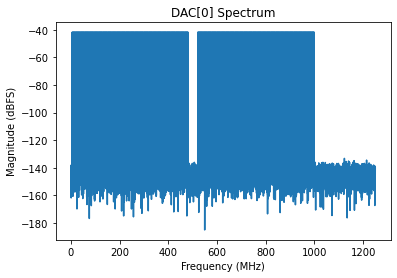

In [4]:
# Enable the processing of DAC waveforms on the PS CPU
FrameCount = root.DacProcessor[0].FrameCount.get()
root.DacProcessor[0].RxEnable.set(True)
while( (FrameCount+5) > root.DacProcessor[0].FrameCount.get() ): time.sleep(0.1)
root.DacProcessor[0].RxEnable.set(False)

# Plot the FFT
plt.title("DAC[0] Spectrum") 
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Magnitude (dBFS)") 
plt.plot(root.DacProcessor[0].Freq.value(), root.DacProcessor[0].Magnitude.value())

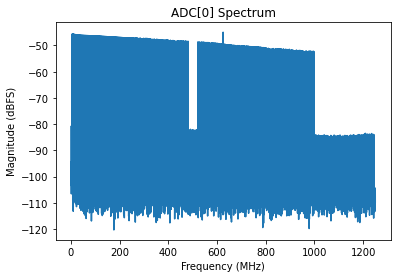

In [5]:
# Enable the processing of ADC waveforms on the PS CPU
FrameCount = root.AdcProcessor[0].FrameCount.get()
root.AdcProcessor[0].RxEnable.set(True)
while( (FrameCount+5) > root.AdcProcessor[0].FrameCount.get() ): time.sleep(0.1)
root.AdcProcessor[0].RxEnable.set(False)

# Plot the FFT
plt.title("ADC[0] Spectrum") 
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Magnitude (dBFS)") 
plt.plot(root.AdcProcessor[0].Freq.value(), root.AdcProcessor[0].Magnitude.value())

In [6]:
# Lets turn off all the continous streaming from ring buffers
for i in range(16):
    root.XilinxZcu216.Application.AppRingBuffer.Adc.Ch[i].ContinuousMode.set(0)
    root.XilinxZcu216.Application.AppRingBuffer.Dac.Ch[i].ContinuousMode.set(0)

# Remove previous dataset
if os.path.isfile(f'{top_level}/test.dat'):
    os.remove(f'{top_level}/test.dat')    
    
# Setup and open the file writer
writer = root.dataWriter._writer
writer.open(f'{top_level}/test.dat')

# Wait for the file write to open the file
while( writer.isOpen() is False):
    time.sleep(0.1)

# Wait a little bit for the file to open up
time.sleep(1.0)    
    
# Trigger 10 waveform burst from DAC[0]
root.XilinxZcu216.Application.AppRingBuffer.Dac.Ch[0].TrigBurst.set(10)

# Wait for the file write to write the 10 waveforms
while(writer.getFrameCount() < 10): time.sleep(0.1)

# Print the status
print( f'Number of frames received: {writer.getFrameCount()}' )
        
# Close the file writer
writer.close()

# Wait for the file write to close the file
while( writer.isOpen() is True):
    time.sleep(0.1)

Number of frames received: 10


In [7]:
debug = False
with pr.utilities.fileio.FileReader(files=f'{top_level}/test.dat') as fd:   
    
    # Loop through the file data
    for header,data in fd.records():

        if debug or (header.error>0):
            # Look at record header data
            print(f"Processing record. Total={fd.totCount}, Current={fd.currCount}")
            print(f"Record size    = {header.size}")
            print(f"Record channel = {header.channel}")
            print(f"Record flags   = {header.flags:#x}")
            print(f"Record error   = {header.error:#x}")

        # Check for polling variable data
        if header.channel == 64:
            # Convert the byte array into a string and remove end of line char at the end
            print(str(data, 'UTF-8').strip('\n'))

        # ADC Ring Buffer Path
        elif header.channel < 16:
            print( f'ADC[CH={header.channel}].size = {header.size} bytes')

        # DAC Ring Buffer Path
        elif header.channel < 32:
            print( f'DAC[CH={header.channel-16}].size = {header.size} bytes')

        else:
            print('UNDEFINED DATA STREAM!!!')

DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes
DAC[CH=0].size = 32768 bytes


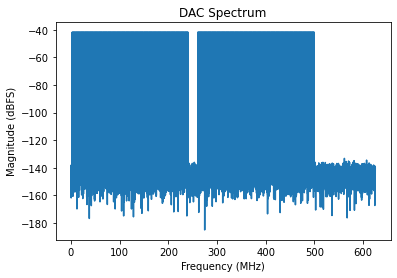

In [8]:
# Convert byte array into int16 array for last DAC waveform received
wrdSize = header.size//2
dacValue = np.frombuffer(data, dtype='int16', count=wrdSize)

# Calculate the FFT
freq = np.fft.fft(dacValue)/float(wrdSize)
freq = freq[range(wrdSize//2)]

# Calculate the magnitude
magnitude = 20.0*np.log10(np.abs(freq)/32767.0) # Units of dBFS

# Calculate the time/frequency x-axis arrays
timeBin  = 1.0E+9/2.5E+9 # Units of ns
freqBin  = (0.5E+3/timeBin)/float(wrdSize) # Units of MHz
timeSteps = np.linspace(0, timeBin*(wrdSize-1), num=wrdSize)
freqSteps = np.linspace(0, freqBin*(wrdSize//2-1), num=wrdSize//2)

# Plot the FFT
plt.title("DAC Spectrum") 
plt.xlabel("Frequency (MHz)") 
plt.ylabel("Magnitude (dBFS)") 
#plt.plot(timeSteps, dacValue)
plt.plot(freqSteps, magnitude)